In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #for debugging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def cls_solve(A,b,C,d):
    m,n = np.shape(A)
    p,n = np.shape(C)
    Q,R = npl.qr(np.vstack([A,C]))
    Q1 = Q[0:m,:]
    # print("q1 shape is ",Q1.shape)
    Q2 = Q[m:m+p,:]
    Qtil, Rtil = npl.qr(Q2.T)
    # print("qtil and Rtil")
    # print(Qtil.shape, Rtil.shape)
    first = np.vstack((np.matmul(np.matmul(2*Qtil.T, Q1.T),b)))
    # print("first shape")
    # print(first.shape)
    denom = first - np.vstack((2*(npl.lstsq(Rtil.T, d, rcond=None)[0])))
    k = npl.lstsq(Rtil, denom, rcond=None)[0]
    return npl.lstsq(R, np.vstack(np.matmul(Q1.T, b)) - np.matmul(Q2.T , k)/2, rcond=None)[0]
def lqe(A, B, C,G, y1, T, lam,rcond):
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]
    shape1 = (T * p, m*(T-1))
    Atil_top = np.kron(np.eye(T), C)  # This is 200 x 400
    Additional_matrix = np.random.rand(T * p, T - 5)  # Adjust dimensions to match Atil_top width

# Ensure the zeros array used in the concatenation below is of correct dimensions
    zeros_shape = (T * p, m * (T - 1))
    Atil_top_extended = np.hstack((Atil_top, Additional_matrix))

# Review dimensions for the block operation
    Atil = np.block([[Atil_top_extended, np.zeros(zeros_shape)],[np.zeros((m * (T - 1), Atil_top_extended.shape[1])), np.sqrt(lam) * np.eye(m * (T - 1))]])
    # print(Atil.shape,"#########")
    y_flat = y1.T.flatten()
    zeros_part = np.zeros(m * (T-1))
    btil = np.concatenate((y_flat, zeros_part)).reshape(-1, 1)
    # print(btil.shape)
    Ctil = np.block([
    [np.kron(np.eye(T-1), A) - np.eye(n * (T-1 ), k=n), np.kron(np.eye(T-1), G), np.kron(np.eye(T-1), B)]])
    print(Ctil.shape,"####")
    dtil = np.zeros(n * (T - 1))
    # print(dtil.shape)
    z = cls_solve(Atil, btil, Ctil, dtil)
    x_hat = [z[i * n:(i + 1) * n] for i in range(T)]
    u_hat_start_index = T * n
    u_hat_end_index = u_hat_start_index + (T)
    u_hat = [z[u_hat_start_index + i : u_hat_start_index + (i + 1) ] for i in range(T - 1)]
    w_hat_start_index = u_hat_end_index
    w_hat_end_index = w_hat_start_index + (T - 1) * p
    w_hat = [z[w_hat_start_index + i * p: w_hat_start_index + (i + 1) * p] for i in range(T - 1)]
    return x_hat,u_hat,z,w_hat,Atil,btil
### ALL THE INPUT CASES###
lambda_values = np.logspace(-4,6, num=20)
def calculate_x_next(t, x, w, A, B, G, u):
    # Base case: ensure initial state is returned as a column vector
    if t == 0:
        return np.array(x[0]).reshape(-1, 1)

    # Check if state at time t has already been calculated
    if len(x) > t:
        return np.array(x[t]).reshape(-1, 1)

    # Recursive call to get the previous state
    x_prev = calculate_x_next(t - 1, x, w, A, B, G, u)

    # Process noise and control input for the current timestep
    w_t = np.array(w[t - 1]).reshape(-1, 1)
    u_t = np.array([u[t - 1]] if t - 1 < len(u) else [0]).reshape(-1, 1)

    # State update equation
    x_t = A @ x_prev + B @ w_t + G @ u_t

    # Append the newly calculated state to the state vector list
    x.append(x_t.flatten())  # Store as a 1D array for easier handling

    # Return the new state as a column vector
    return x_t



############## Input Cases#################
T = 80
lam=1e+3
# A = np.block([[np.eye(2), np.eye(2)], [np.zeros((2, 2)), np.eye(2)]])
A = np.array([[0.9, 0, 1, 0],
              [0, 0.9, 0, 1],
              [0, 0, 0.9, 0],
              [0, 0, 0, 0.9]])
B = np.block([[np.zeros((2, 2))], [np.eye(2)]])
C = np.block([[np.eye(2), np.zeros((2, 2))]])
G = np.random.rand(4, 1)
n, m, K = A.shape[0], B.shape[1], C.shape[0]
P = np.eye(m)
a=0.5
R = np.eye(K)*a**2
Q = np.eye(n)*a**2
w = [np.random.multivariate_normal(mean=np.zeros(m), cov=P) for _ in range(T)]
v = [np.random.multivariate_normal(mean=np.zeros(K), cov=R) for _ in range(T)]
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]

# Sinusoidal input generation
A_sin = 1  # Amplitude
f_sin = 0.2 # Frequency
phi_sin = 0  # Phase shift
u = A_sin * np.sin(2 * np.pi * f_sin * np.arange(T) + phi_sin)
print("u.shape is")
print(len(u))
print("##############")

# Initialize the state list with the initial condition
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]

# Calculate x for each timestep up to T
for t in range(1, T + 1):
    # print(f'Calculating state at time {t}')  # Debug print
    calculate_x_next(t, x, w, A, B, G, u)

# Convert the list of states to a numpy array for easier handling
x_array = np.array(x)
y = [C @ x_array[t] + v[t] for t in range(T)]
y1 = np.concatenate(y)
# rcond=-1
# type(y1)
y=np.array(y1)
print(y.shape)
# type(y)
# print(y.shape)
lambda_values = np.logspace(-4,5, num=20)# lamda value is assigned as 10^3
rcond=-1
x_hat,u_hat,z,w_hat,Atil,btil = lqe(A, B, C,G, y, T, lam,rcond)
print(type(z))
print(z.shape)
x_hat=np.array(x_hat)
print(x_hat.shape)
# for i, uh in enumerate(u_hat):
#     print(f"Shape of u_hat[{i}]:", np.array(uh).shape)
# for i, wh in enumerate(w_hat):
#     print(f"Shape of u_hat[{i}]:", np.array(wh).shape)


u_hat=np.array(u_hat)
print(type(u_hat))
print(u_hat)
print(u_hat.shape)

print("##########")
print(len(w_hat))
# print(u_hat)

u.shape is
80
##############


array([[ 0.44779611],
       [-0.19999333],
       [-0.50984759],
       [-0.25944471]])

array([[ 0.22513173],
       [ 0.41977103],
       [-1.13273102],
       [-0.12986557]])

array([[-0.72494816],
       [ 0.77894919],
       [-0.03497056],
       [-0.18010977]])

array([[-0.89258821],
       [-0.01007633],
       [ 0.60639884],
       [-0.18733685]])

array([[-0.52889338],
       [-1.05561528],
       [-0.42155088],
       [-1.30907807]])

array([[-0.89755492],
       [-2.25913183],
       [-2.24936032],
       [-1.12222965]])

array([[-2.72519693],
       [-2.29623856],
       [-2.81371337],
       [-1.20894287]])

array([[-5.06122629],
       [-2.74453675],
       [-2.22498899],
       [-1.0636095 ]])

array([[-6.98525696],
       [-4.0647134 ],
       [-1.84879069],
       [-2.65957956]])

array([[-8.46748478],
       [-7.17703136],
       [-2.43289775],
       [-2.81538119]])

array([[-10.05363405],
       [ -9.27470941],
       [ -1.71034112],
       [ -2.58137053]])

array([[-10.42664894],
       [-10.06939926],
       [ -1.35175942],
       [ -1.95654119]])

array([[-10.53057917],
       [-10.4879797 ],
       [ -0.402455  ],
       [  1.30521384]])

array([[-10.08514055],
       [ -8.66498872],
       [ -1.19803073],
       [  0.82123654]])

array([[-10.60662005],
       [ -7.83646305],
       [ -0.54671198],
       [  0.74986702]])

array([[-10.09267002],
       [ -6.30294972],
       [  0.02028314],
       [  0.62013897]])

array([[-8.73115705],
       [-4.19330604],
       [-0.81551541],
       [ 1.64202323]])

array([[-8.46839244],
       [-1.60093138],
       [-0.53482156],
       [ 0.15868808]])

array([[-8.36153907],
       [-1.81317098],
       [ 0.82982913],
       [-0.2610383 ]])

array([[-7.02751885],
       [-2.75210192],
       [ 0.85700583],
       [-2.84812699]])

array([[-5.46776114],
       [-5.32501872],
       [ 0.40172895],
       [-2.11407314]])

array([[-4.18729325],
       [-6.04738024],
       [-0.23032653],
       [-1.60182306]])

array([[-3.79372615],
       [-6.51344446],
       [-0.26618953],
       [-1.17090102]])

array([[-3.88570738],
       [-7.56402186],
       [-1.13913284],
       [-0.58635383]])

array([[-4.96823231],
       [-8.25318324],
       [-0.66968326],
       [ 0.28252735]])

array([[-5.14109234],
       [-7.14533757],
       [ 0.37542329],
       [-0.40092163]])

array([[-3.91959699],
       [-5.9725157 ],
       [ 0.60299022],
       [-0.05242214]])

array([[-2.71948276],
       [-4.89666544],
       [ 2.7335553 ],
       [ 2.64279184]])

array([[ 0.08085651],
       [-2.29522788],
       [ 2.68754133],
       [ 2.42090971]])

array([[ 2.42834936],
       [-0.50400512],
       [ 1.4592403 ],
       [ 1.90736168]])

array([[3.64475472],
       [1.45375707],
       [1.71627836],
       [0.32076579]])

array([[5.32852043],
       [2.4883569 ],
       [2.49291206],
       [0.18718743]])

array([[7.49374476],
       [2.95772946],
       [0.70677653],
       [1.03255437]])

array([[7.2459825 ],
       [3.16349006],
       [0.28621523],
       [0.52842311]])

array([[6.47563666],
       [2.51635442],
       [1.26731847],
       [1.98674913]])

array([[7.09539146],
       [4.25146811],
       [0.66610496],
       [1.59037304]])

array([[ 7.3839201 ],
       [ 6.27590408],
       [ 1.66577786],
       [-0.10496962]])

array([[8.51647026],
       [6.07436488],
       [1.65795666],
       [0.36574335]])

array([[ 9.11761559],
       [ 5.30165091],
       [ 0.99777394],
       [-0.16136893]])

array([[ 8.87166515],
       [ 3.75090715],
       [-1.01621104],
       [ 1.17649833]])

array([[6.96828759],
       [4.55231476],
       [0.48983657],
       [0.32646458]])

array([[ 7.09325823],
       [ 5.28275761],
       [ 1.07741254],
       [-0.31280859]])

array([[ 7.66650926],
       [ 4.97269408],
       [ 1.10090486],
       [-0.6987327 ]])

array([[ 7.79559889],
       [ 3.24567116],
       [ 1.17442444],
       [-1.16870213]])

array([[ 7.85850061],
       [ 0.89319217],
       [ 0.61960263],
       [-1.36022862]])

array([[ 7.69225317],
       [-0.55635567],
       [-0.02494293],
       [ 0.78198697]])

array([[ 7.23004775],
       [ 1.14047661],
       [-0.90178478],
       [ 0.95955695]])

array([[ 5.81042251],
       [ 2.51700672],
       [-0.01665304],
       [ 1.33450901]])

array([[ 5.00756291],
       [ 3.06879424],
       [-0.81627874],
       [-0.2382154 ]])

array([[ 3.35856505],
       [ 1.66448968],
       [-0.49960178],
       [ 0.00432859]])

array([[ 2.52310677],
       [ 1.5023693 ],
       [ 0.21607328],
       [-0.87056196]])

array([[ 2.81883219],
       [ 1.34078015],
       [ 1.4290117 ],
       [-0.00460686]])

array([[ 4.17112498],
       [ 1.7331161 ],
       [ 0.65848731],
       [-0.73874499]])

array([[4.20733548],
       [0.29003868],
       [1.44395035],
       [0.72166086]])

array([[ 4.89858945],
       [ 0.12348592],
       [ 0.38822418],
       [-0.57517925]])

array([[ 4.79695468],
       [-0.46404192],
       [-0.44104883],
       [ 1.04459257]])

array([[ 4.20817321],
       [ 1.48616459],
       [-0.50647546],
       [ 2.30179523]])

array([[3.48604473],
       [4.17036418],
       [0.11049467],
       [1.14759849]])

array([[ 3.04277062],
       [ 4.36990543],
       [-0.9758165 ],
       [ 1.87797867]])

array([[ 1.43071423],
       [ 4.95168381],
       [-2.07592479],
       [-1.27805903]])

array([[-0.78828198],
       [ 3.1784564 ],
       [-2.31070763],
       [-2.11826374]])

array([[-2.68819859],
       [ 1.60155676],
       [-3.39878219],
       [-1.75270597]])

array([[-5.61299661],
       [ 0.21971593],
       [-2.51245747],
       [-2.92745189]])

array([[-7.76931872],
       [-3.26072837],
       [-1.19240803],
       [-4.14562074]])

array([[-8.51675771],
       [-7.93948602],
       [-1.40106039],
       [-4.06030568]])

array([[-9.06614233e+00],
       [-1.12058431e+01],
       [-3.25400615e-03],
       [-5.14865357e+00]])

array([[ -7.83081928],
       [-14.37470261],
       [  0.96403116],
       [ -4.85360341]])

array([[ -5.87854188],
       [-17.25981494],
       [  0.29500585],
       [ -5.73391726]])

array([[ -5.20084615],
       [-21.79877153],
       [  0.60063408],
       [ -3.17779252]])

array([[ -4.41209028],
       [-23.65589664],
       [  1.64644026],
       [ -3.61922121]])

array([[ -2.32444099],
       [-24.90952819],
       [  1.14872724],
       [ -3.38012429]])

array([[ -0.61130683],
       [-24.93948992],
       [  1.07020532],
       [ -1.5721946 ]])

array([[  0.72519347],
       [-23.4867147 ],
       [  0.96740909],
       [ -0.23876927]])

array([[  1.41491891],
       [-21.90783332],
       [ -0.14981416],
       [ -1.34246408]])

array([[  0.79165003],
       [-21.91872381],
       [ -0.12991103],
       [ -1.09058023]])

array([[  0.582574  ],
       [-20.81743166],
       [ -0.13277056],
       [ -2.75196837]])

array([[  0.72350886],
       [-20.62844712],
       [  0.42447714],
       [ -1.32399185]])

array([[  1.28079942],
       [-19.35857344],
       [  0.35918888],
       [  0.08657505]])

array([[  1.30674405],
       [-17.86716186],
       [ -0.16868263],
       [ -0.70233847]])

array([[  0.67542419],
       [-17.64199389],
       [ -1.06355364],
       [  0.55339225]])

(160,)
(316, 553) ####
<class 'numpy.ndarray'>
(553, 1)
(80, 4, 1)
<class 'numpy.ndarray'>
[[[-5.92017739e+00]]

 [[ 1.56737819e-01]]

 [[-3.69935499e+00]]

 [[-6.46052896e-02]]

 [[ 1.35288755e+00]]

 [[-2.98223252e+00]]

 [[-1.05207591e+00]]

 [[ 6.45541267e-01]]

 [[-8.08395503e-02]]

 [[ 1.51796221e+00]]

 [[ 3.69212080e-01]]

 [[ 7.47620436e-02]]

 [[ 5.91696700e-01]]

 [[-1.71776868e+00]]

 [[-5.59497589e-01]]

 [[-6.85770492e-01]]

 [[ 1.73880988e+00]]

 [[-1.02704152e+00]]

 [[-7.71109600e-01]]

 [[ 5.60734663e-02]]

 [[ 4.22529431e+00]]

 [[-3.36252161e+00]]

 [[-6.07915345e-01]]

 [[ 2.94170958e+00]]

 [[ 1.74947609e-01]]

 [[ 1.87625981e+00]]

 [[ 2.09888734e+00]]

 [[ 1.26006059e+00]]

 [[ 1.33949805e+00]]

 [[ 1.31211500e+00]]

 [[-3.78820133e+00]]

 [[ 2.02192559e-01]]

 [[ 2.44491679e-01]]

 [[ 2.76999841e+00]]

 [[-1.87095700e+00]]

 [[-2.23411387e+00]]

 [[ 1.64088423e+00]]

 [[-5.92272112e-01]]

 [[ 1.54742169e-01]]

 [[-1.23833023e+00]]

 [[ 1.05873998e+00]]

 [[ 4.7

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[0] and Estimated x_hat[0] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

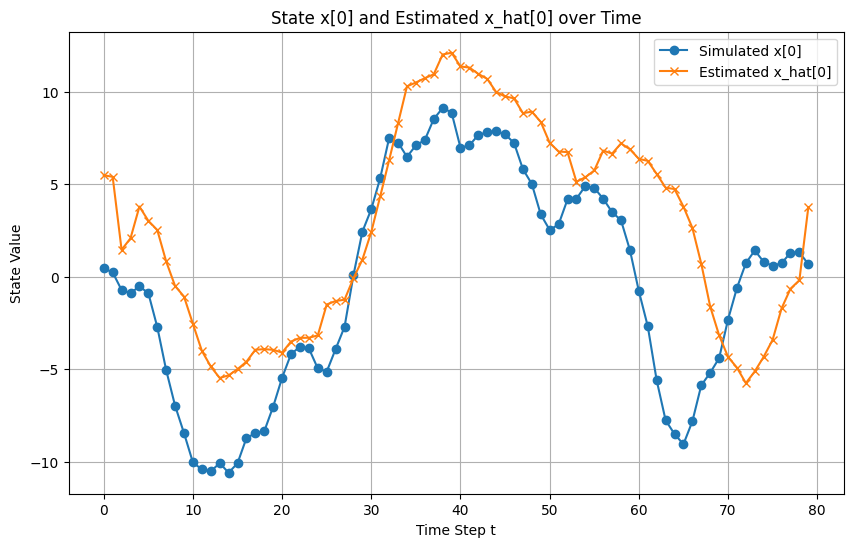

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[1] and Estimated x_hat[1] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

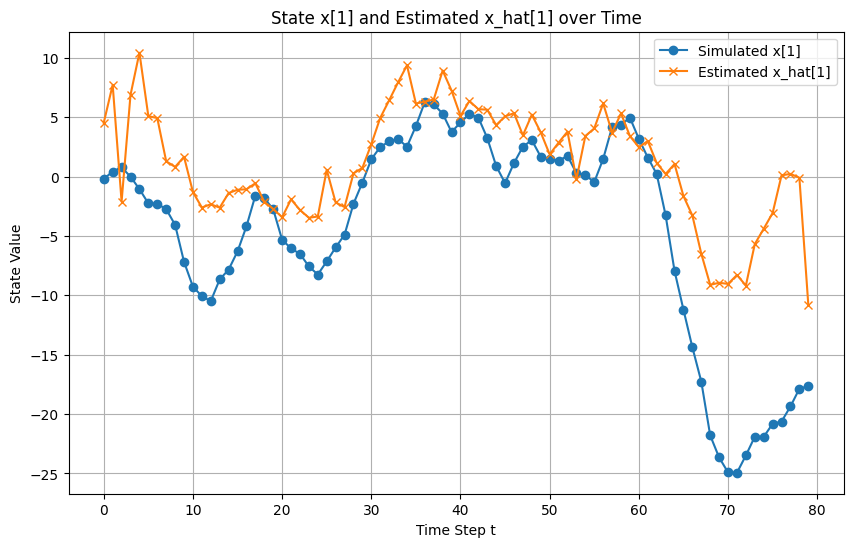

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[2] and Estimated x_hat[2] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

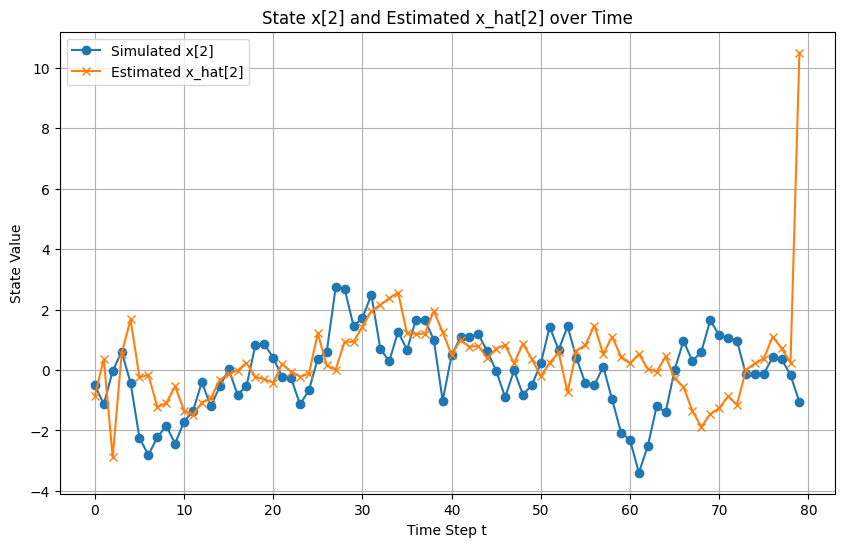

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[3] and Estimated x_hat[3] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

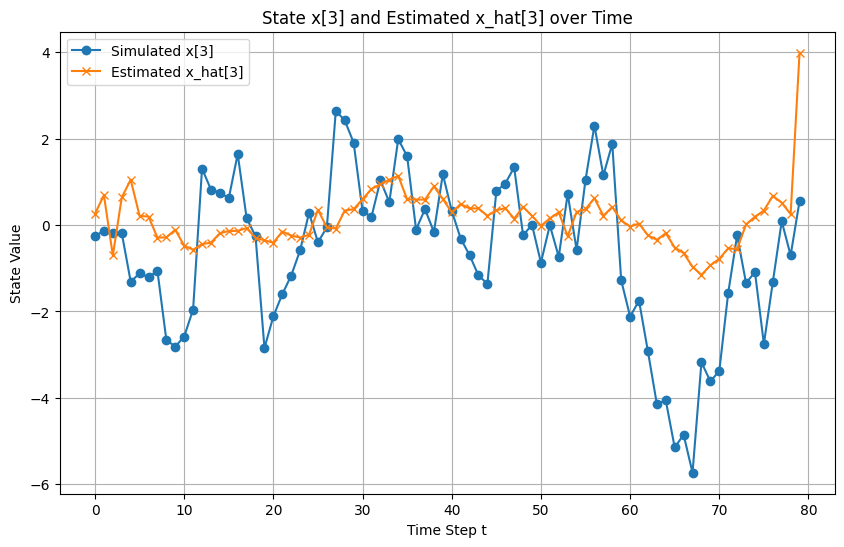

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume x and x_hat are loaded or computed already and are numpy arrays
T = len(x_hat)  # Correct to define T based on the length of x_hat
t = np.arange(T)  # Time vector

# Ensure x_hat is a proper numpy array for slicing
x_hat = np.array(x_hat)  # Ensuring it's numpy array
x = np.array(x)  # Ensuring x is also a numpy array

# Loop through each state component for plotting
for i in range(x.shape[1]):  # This assumes x is 2D (time steps, state variables)
    plt.figure(figsize=(10, 6))

    # Plot simulated state (including all states)
    plt.plot(t, x[1:, i], label=f'Simulated x[{i}]', marker='o')

    # Plot estimated state (ensure x_hat matches dimensions)
    plt.plot(t, x_hat[:, i], label=f'Estimated x_hat[{i}]', marker='x')

    plt.title(f'State x[{i}] and Estimated x_hat[{i}] over Time')
    plt.xlabel('Time Step t')
    plt.ylabel('State Value')
    plt.legend()
    plt.grid(True)
    plt.show()
